In [1]:
# import all necessary libraries
!pip install mysql-connector-python
!pip install vaderSentiment
!pip install tensorflow
!pip install keras
!pip install protobuf
!pip install grpcio
!pip install h5py
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import pandas as pd
import numpy as np
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow
import keras
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import time
import json
import re
import math
import pickle
from datetime import datetime
from datetime import timedelta
import requests
from requests.auth import AuthBase
import config
import tools
import mysql.connector
import urllib.parse
from mysql.connector import errorcode
import sqlite3
%matplotlib inline
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000)

Using TensorFlow backend.


In [2]:
# load training and validation set
with open('pickle-folder/tsla_week1_data.pkl', 'rb') as f:
    train_data = pickle.load(f)
# load test set
with open('pickle-folder/tsla_week2_data.pkl', 'rb') as f:
    test_data = pickle.load(f)

# LSTM - 25 - short - tanh
- 25-dimensionial single layer
- activation = tanh
- epochs = 20
- batch size = 63
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


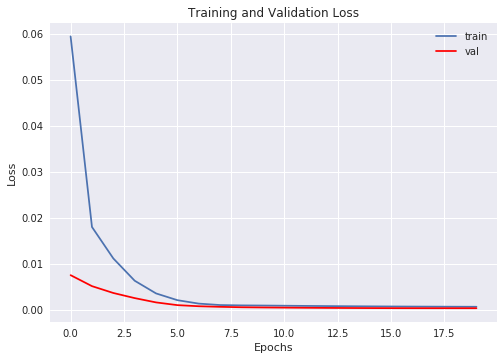

Test RMSE: 1.487
Test RMSE/std_dev: 0.201
Test MAE: 1.057


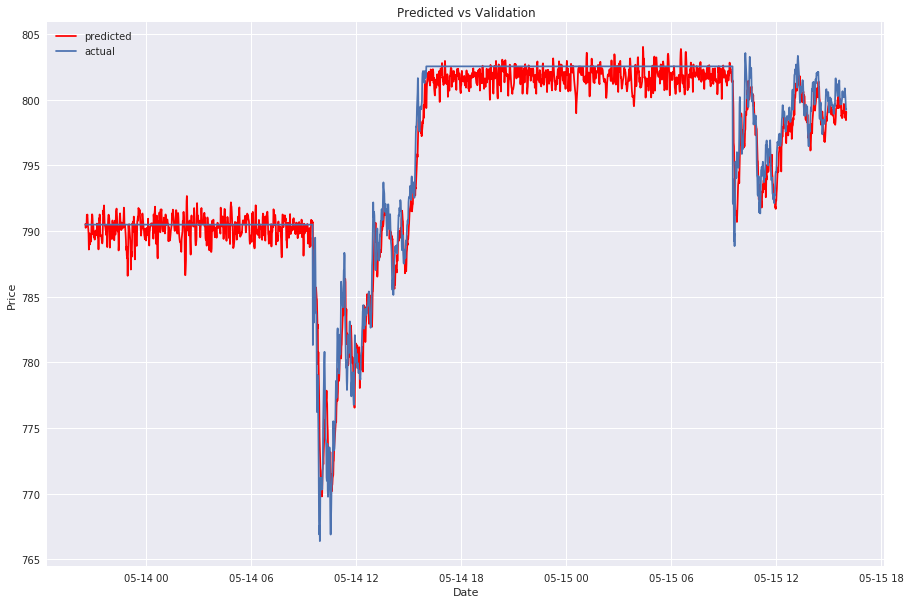

(3540, 270, 4) (3540,) (3265, 270, 4) (3265,)
Test RMSE: 1.192
Test RMSE/std_dev: 0.175
Test MAE: 0.906


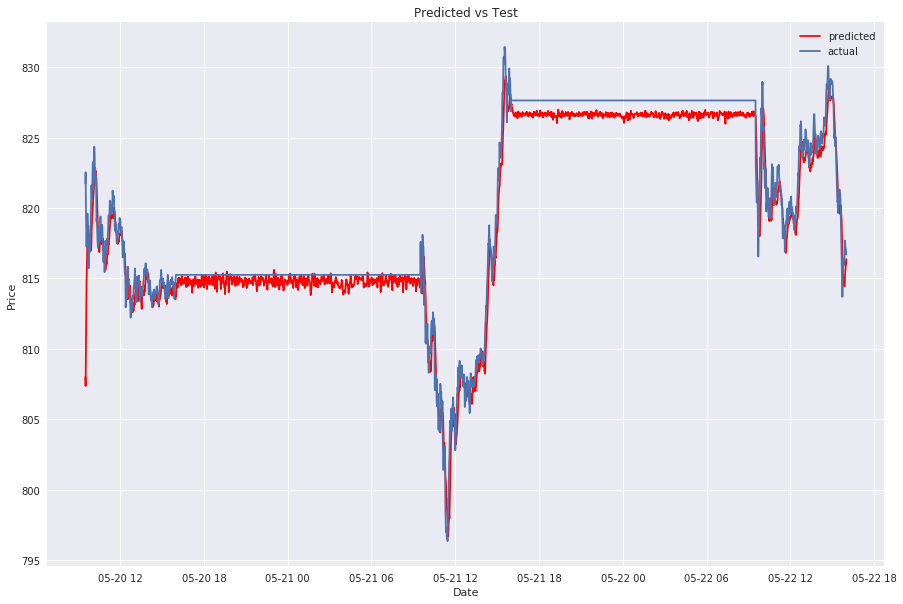

In [6]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, verbose=0, validation_data=(test_X, test_y), shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-2610:], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 25 - short - relu
- 25-dimensionial single layer
- activation = relu
- epochs = 20
- batch size = 63
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


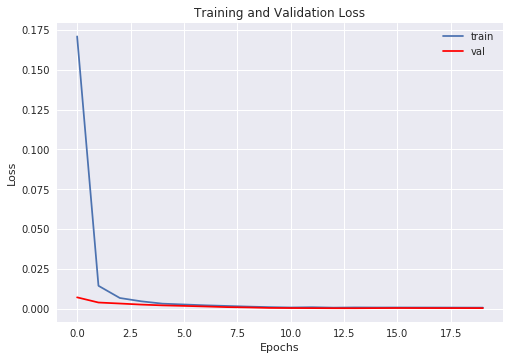

Test RMSE: 1.467
Test RMSE/std_dev: 0.198
Test MAE: 1.156


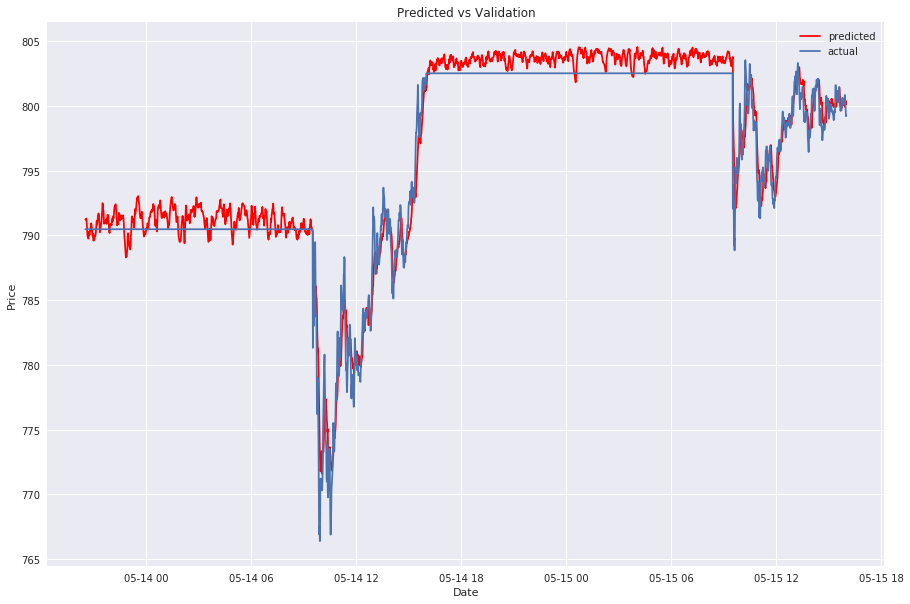

(3540, 270, 4) (3540,) (3265, 270, 4) (3265,)
Test RMSE: 1.101
Test RMSE/std_dev: 0.162
Test MAE: 0.779


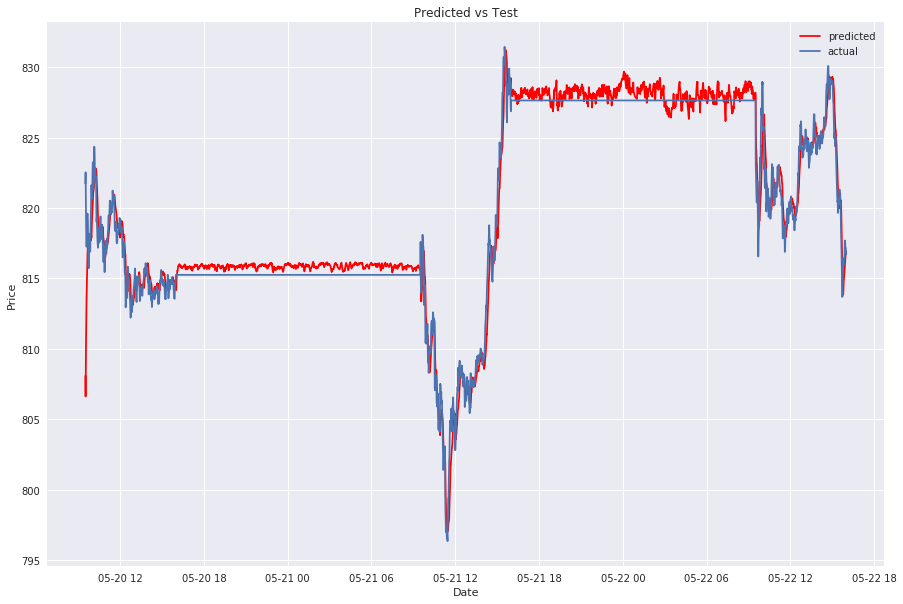

In [8]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(25, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-2610:], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 25 - long - tanh
- 25-dimensional single layer
- activation=tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


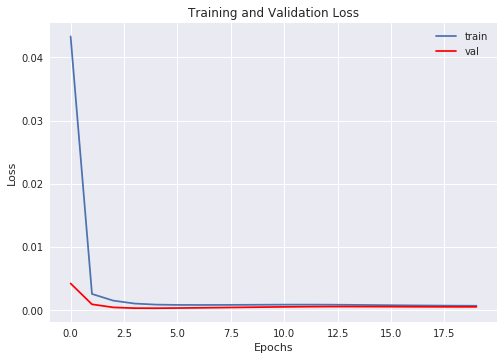

Test RMSE: 1.756
Test RMSE/std_dev: 0.686
Test MAE: 1.537


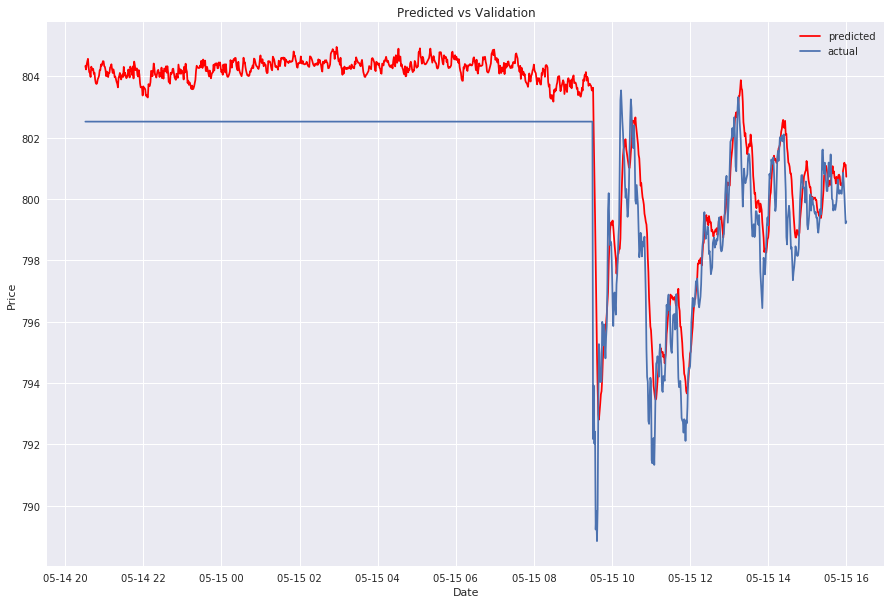

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 0.982
Test RMSE/std_dev: 0.144
Test MAE: 0.666


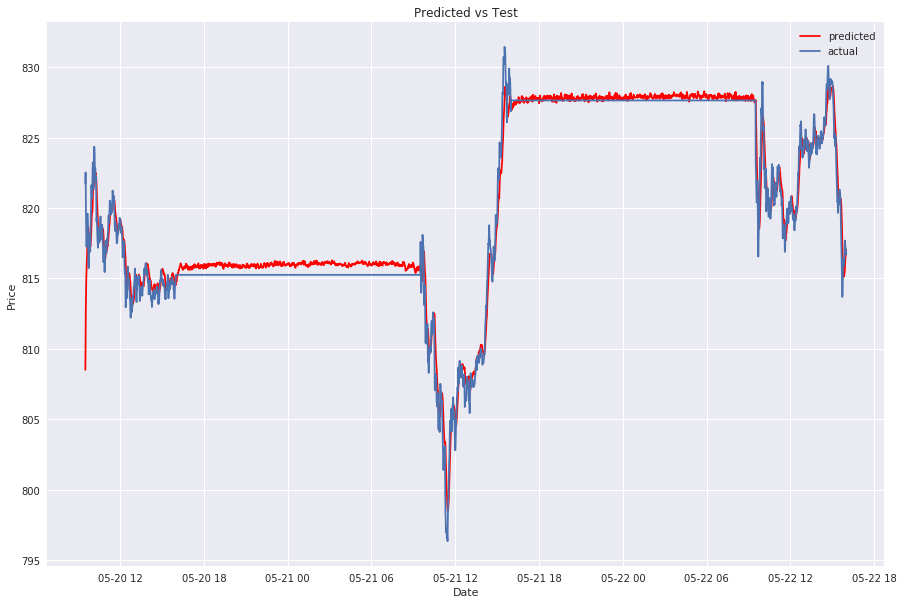

In [10]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(25, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 25 - long - relu
- 25-dimensional single layer
- activation = relu
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


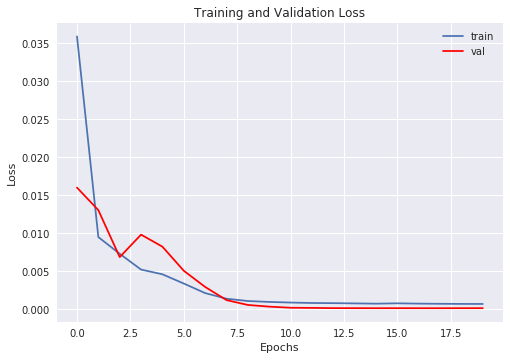

Test RMSE: 0.974
Test RMSE/std_dev: 0.381
Test MAE: 0.642


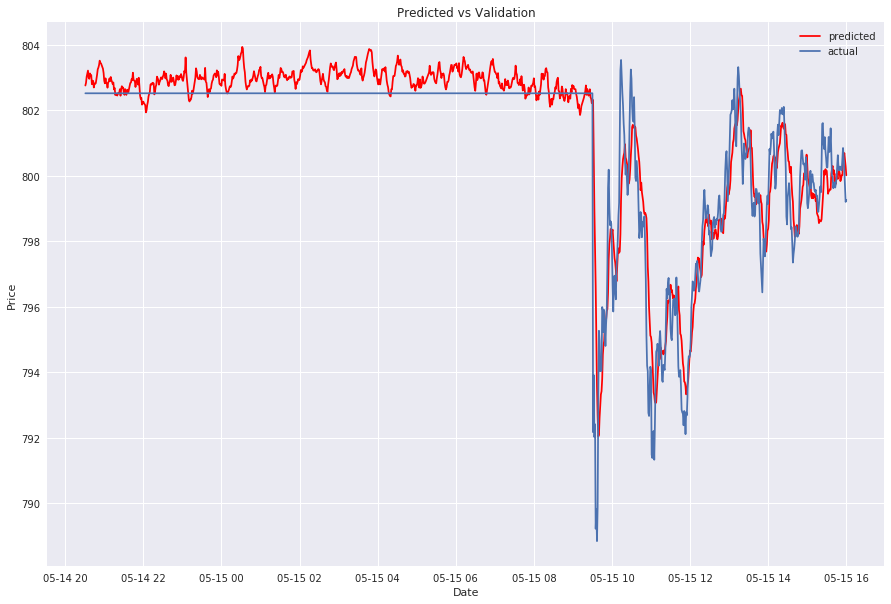

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 0.887
Test RMSE/std_dev: 0.130
Test MAE: 0.510


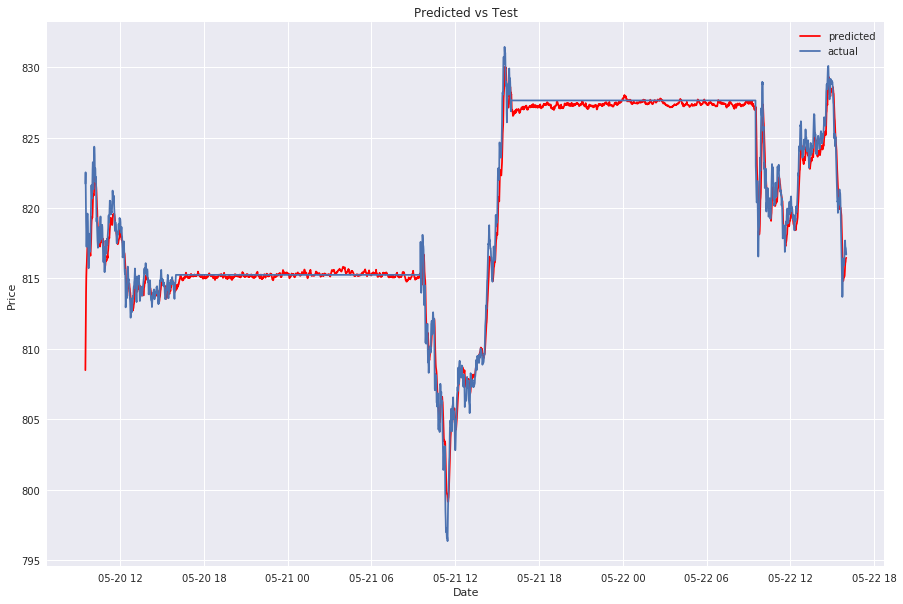

In [11]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(25, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 50 - short - tanh
- 50-dimensionial single layer
- activation = tanh
- epochs = 20
- batch size = 63
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


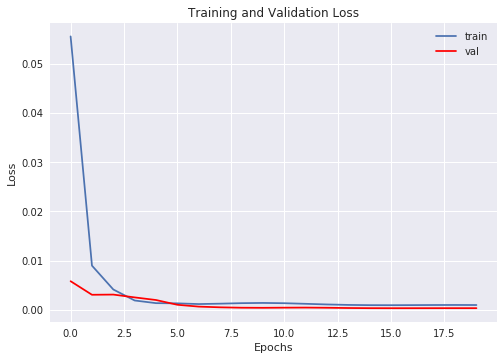

Test RMSE: 1.421
Test RMSE/std_dev: 0.192
Test MAE: 0.951


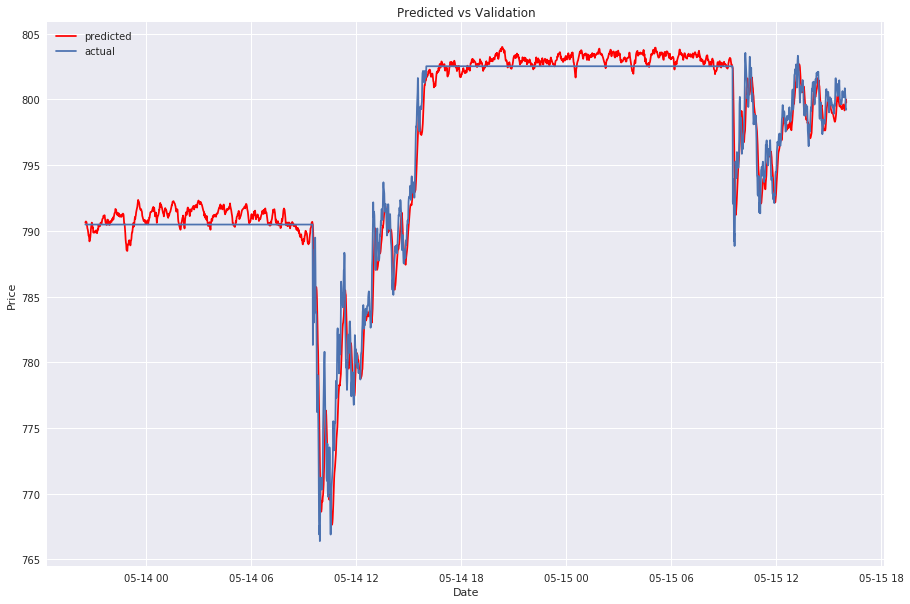

(3540, 270, 4) (3540,) (3265, 270, 4) (3265,)
Test RMSE: 1.142
Test RMSE/std_dev: 0.168
Test MAE: 0.807


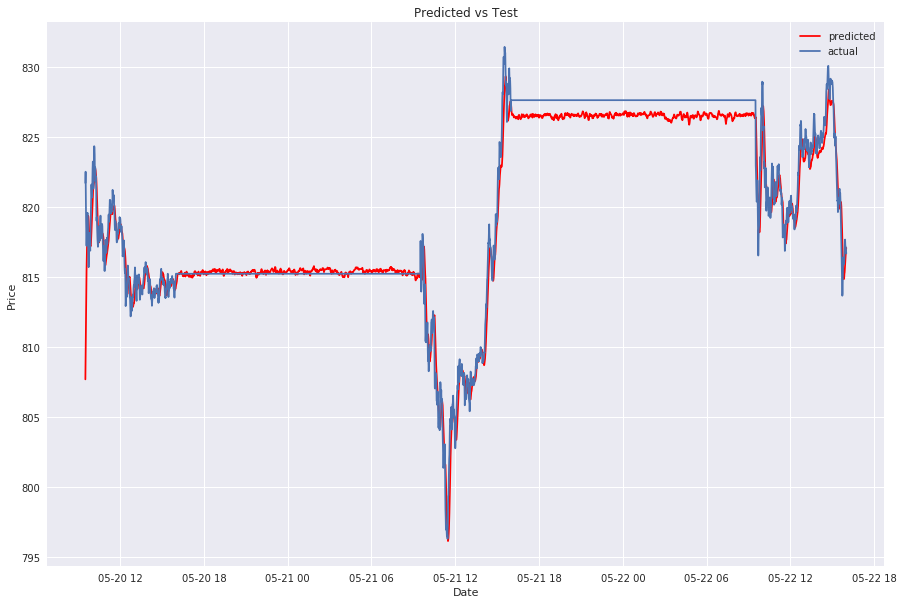

In [12]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-2610:], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 50 - short - relu
- 50-dimensionial single layer
- activation = relu
- epochs = 20
- batch size = 63
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


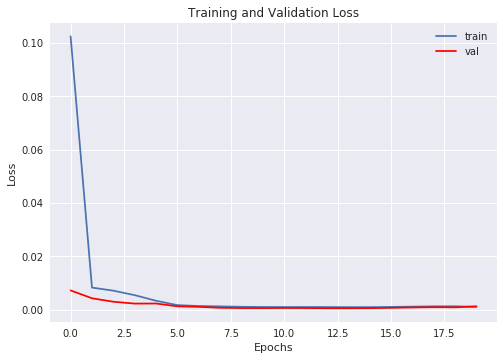

Test RMSE: 2.729
Test RMSE/std_dev: 0.368
Test MAE: 2.379


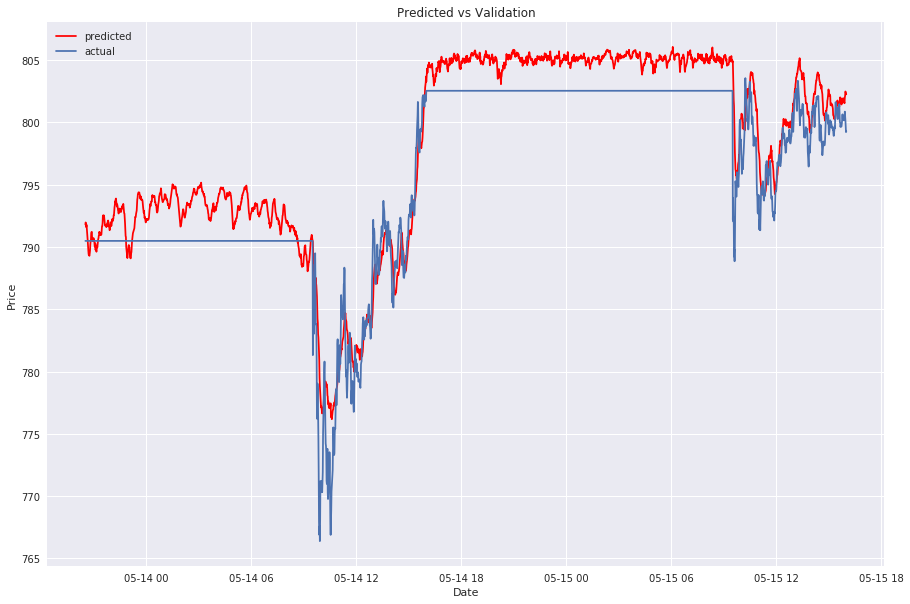

(3540, 270, 4) (3540,) (3265, 270, 4) (3265,)
Test RMSE: 1.227
Test RMSE/std_dev: 0.180
Test MAE: 0.924


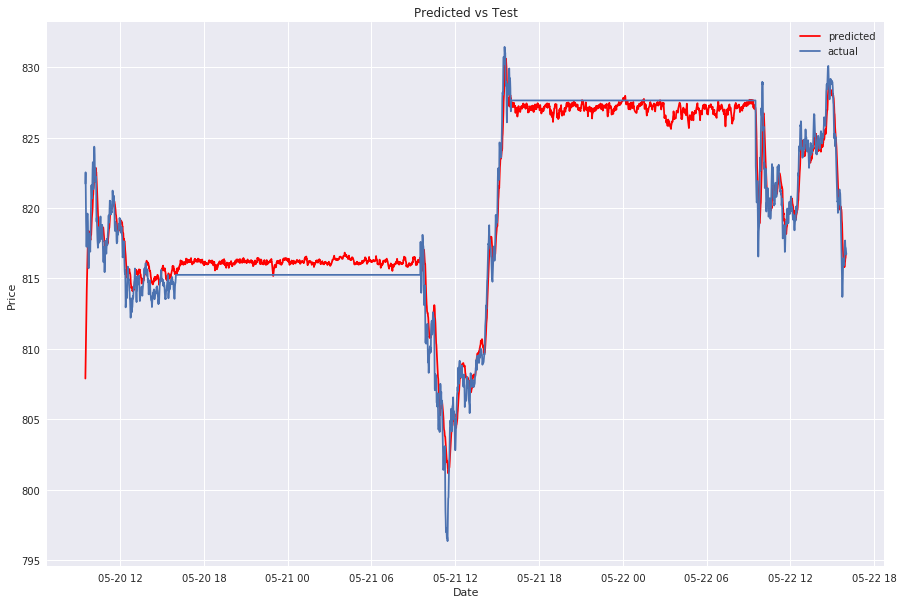

In [13]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-2610:], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 50 - long - tanh
- 64-dimensional single layer
- activation=tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


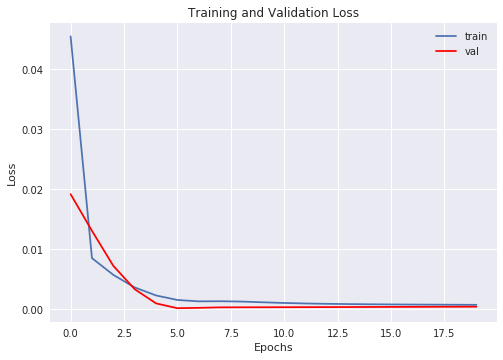

Test RMSE: 1.619
Test RMSE/std_dev: 0.633
Test MAE: 1.418


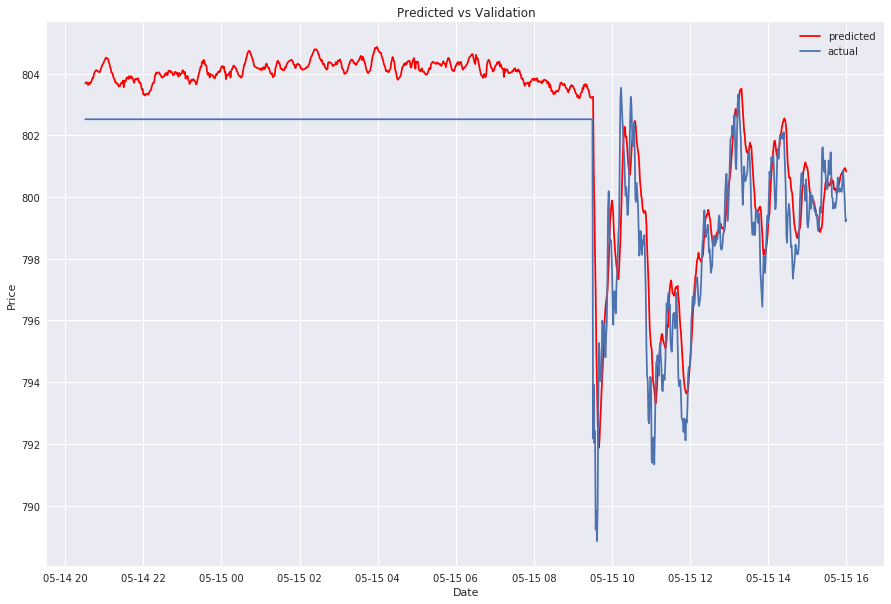

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 0.918
Test RMSE/std_dev: 0.135
Test MAE: 0.623


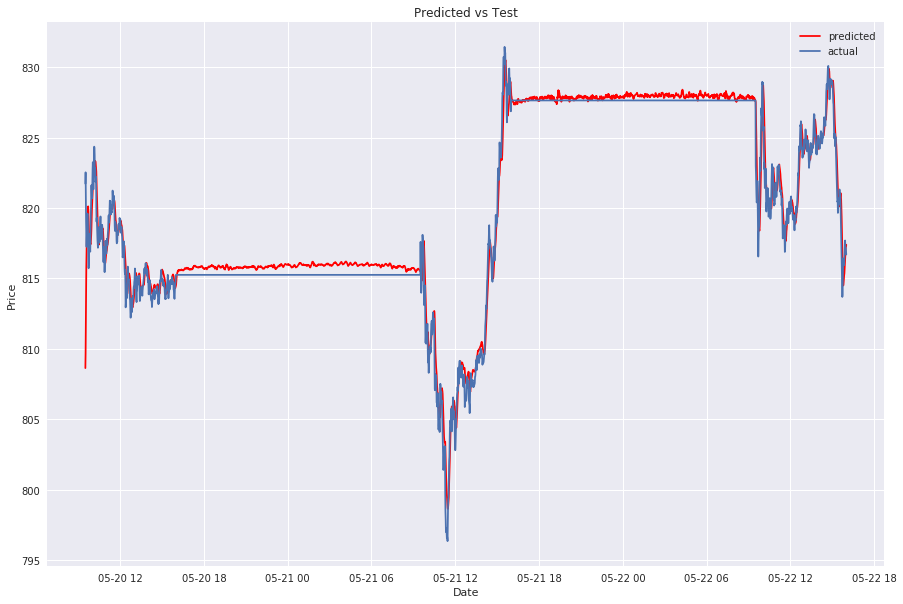

In [14]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 50 - long - relu
- 64-dimensional single layer
- activation = relu
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


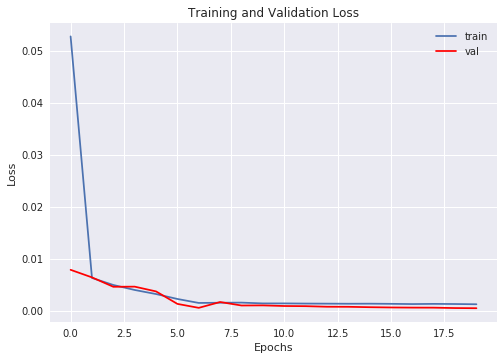

Test RMSE: 1.655
Test RMSE/std_dev: 0.647
Test MAE: 1.469


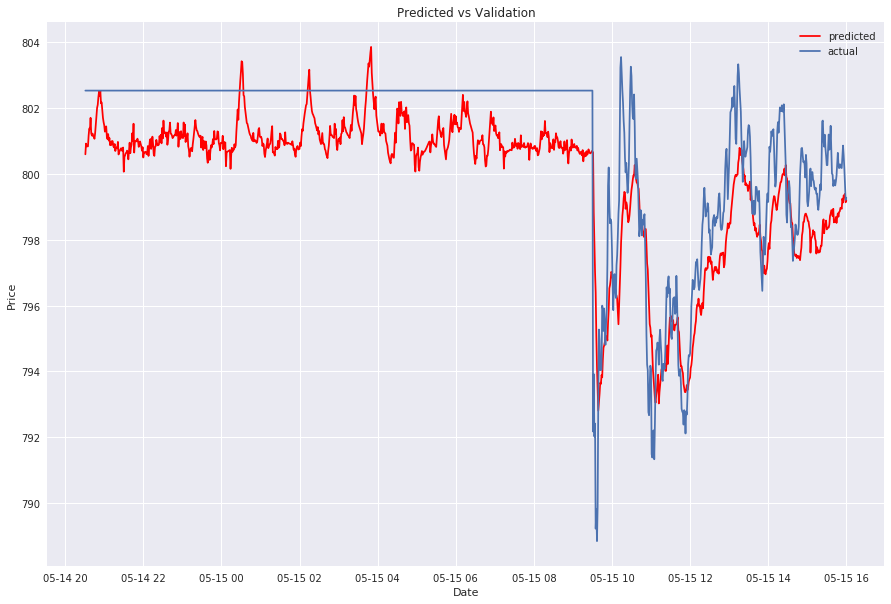

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 1.791
Test RMSE/std_dev: 0.263
Test MAE: 1.562


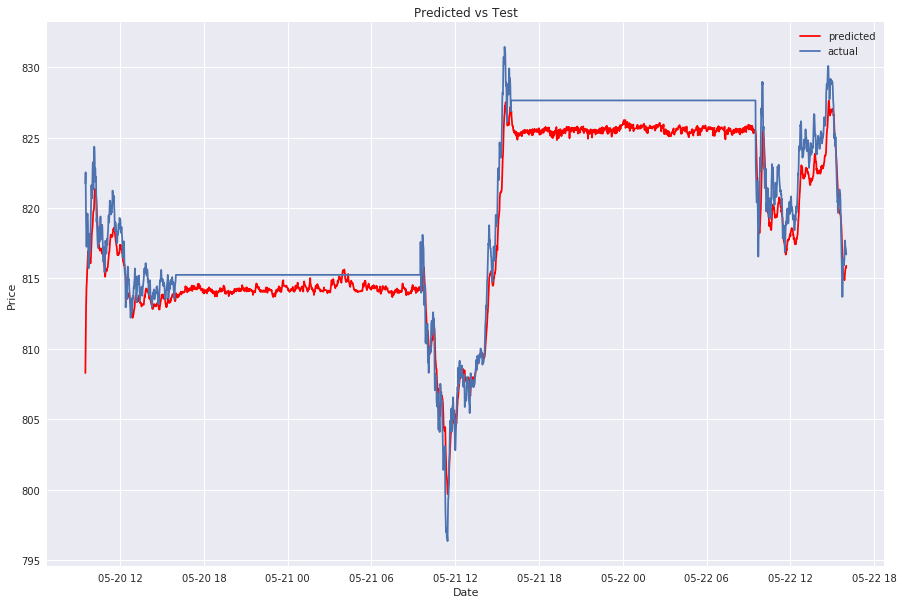

In [15]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(50, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

 # LSTM - 64 - short - tanh
 - 64-dimensional single layer
 - activation=tanh
 - epochs = 20
 - batch size = 64
 - 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


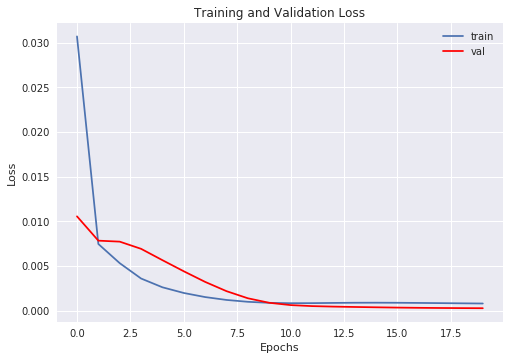

Test RMSE: 1.274
Test RMSE/std_dev: 0.172
Test MAE: 0.783


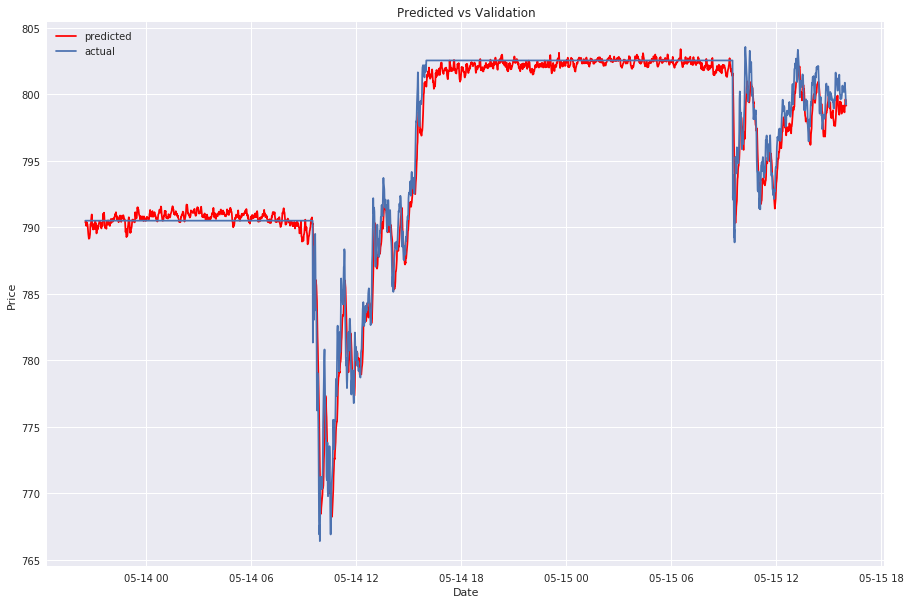

(3540, 270, 4) (3540,) (3265, 270, 4) (3265,)
Test RMSE: 1.211
Test RMSE/std_dev: 0.178
Test MAE: 0.909


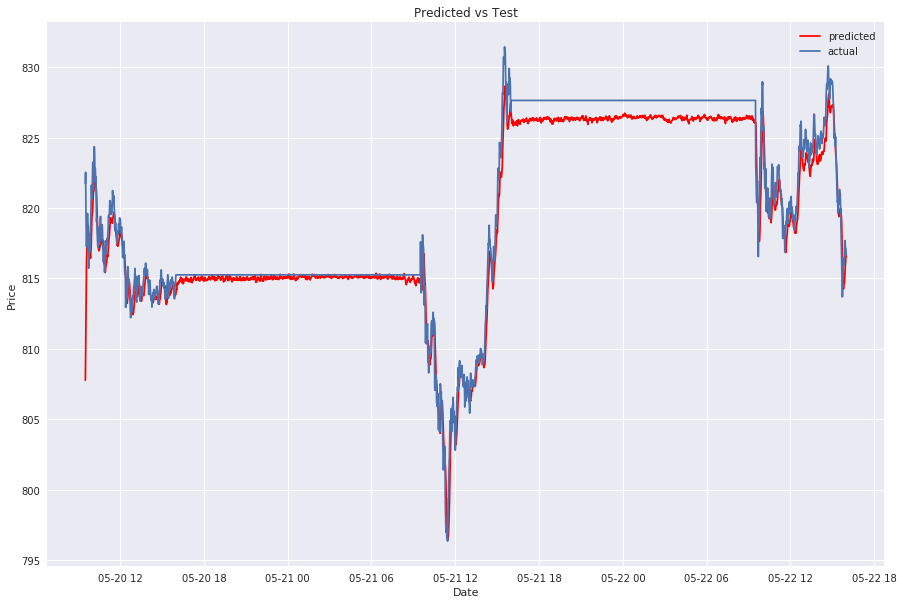

In [16]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-2610:], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 64 - short - relu
- 64-dimensional single layer
- activation=relu
- epochs = 20
- batch size = 64
- 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


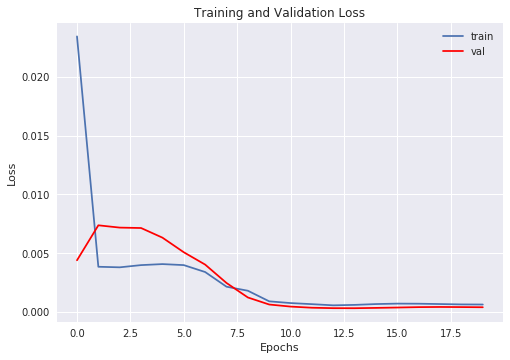

Test RMSE: 1.506
Test RMSE/std_dev: 0.203
Test MAE: 1.183


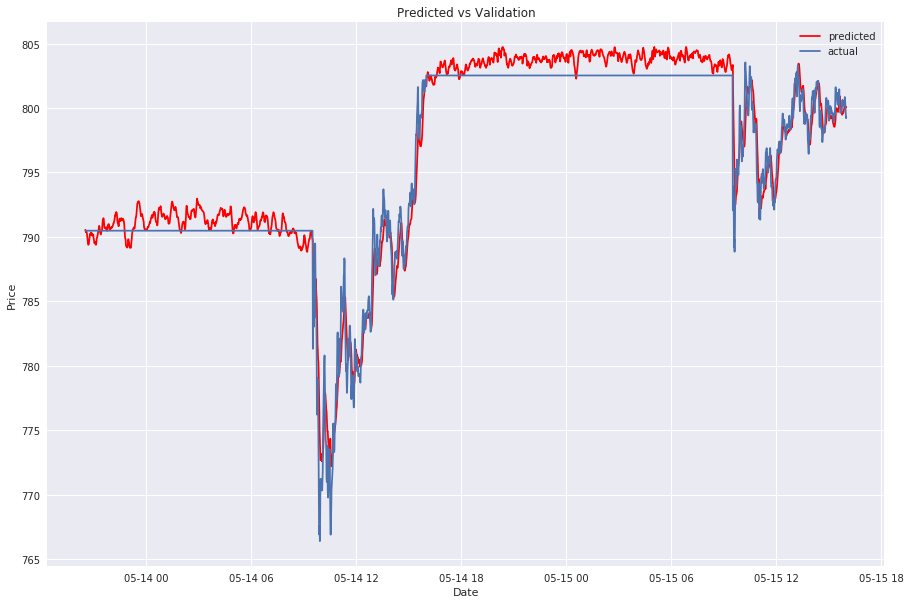

(3540, 270, 4) (3540,) (3265, 270, 4) (3265,)
Test RMSE: 0.979
Test RMSE/std_dev: 0.144
Test MAE: 0.732


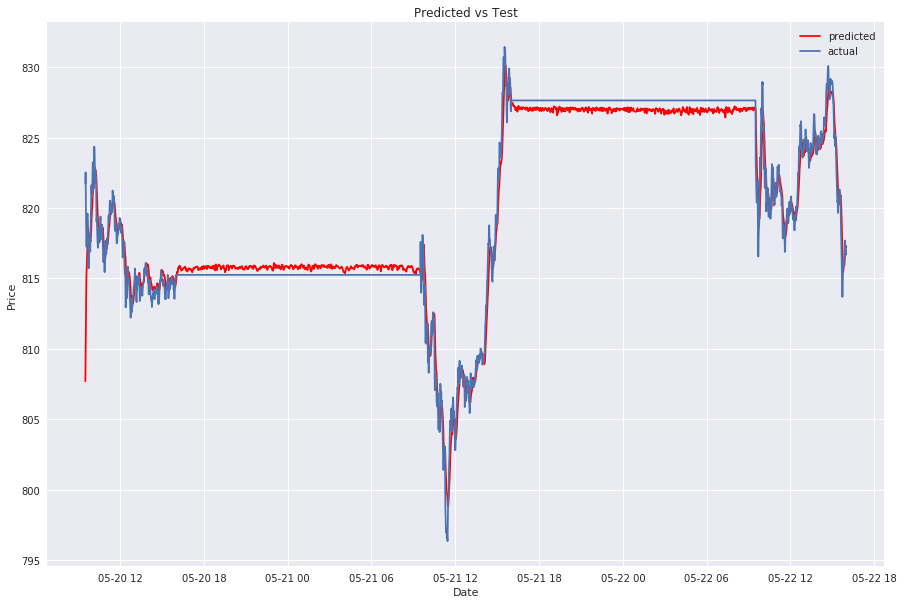

In [17]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-2610:], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 64 - long - tanh
- 64-dimensional single layer
- activation=tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


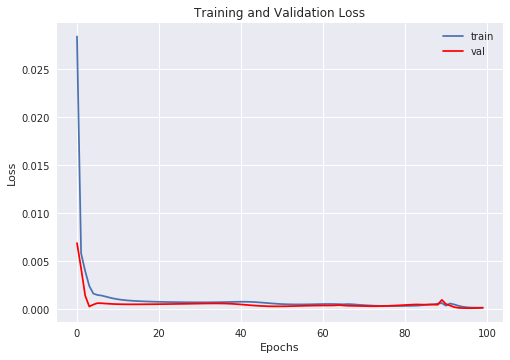

Test RMSE: 1.008
Test RMSE/std_dev: 0.394
Test MAE: 0.865


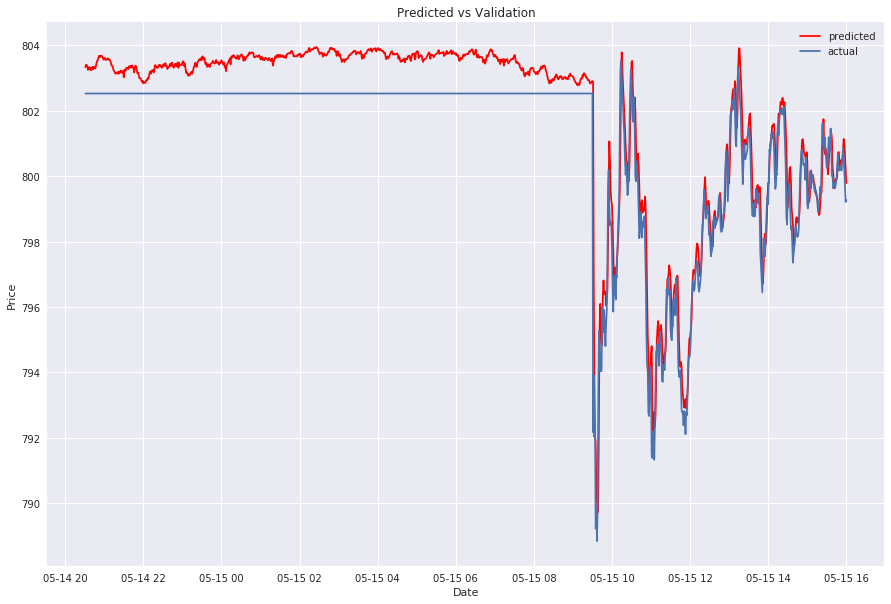

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 0.684
Test RMSE/std_dev: 0.100
Test MAE: 0.523


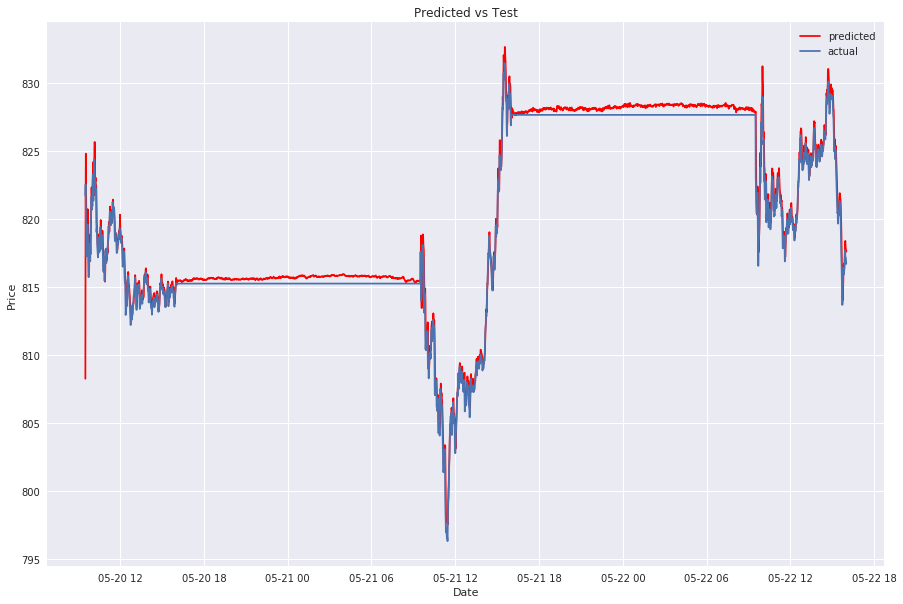

In [18]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 64 - long - relu
- 64-dimensional single layer
- activation=tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


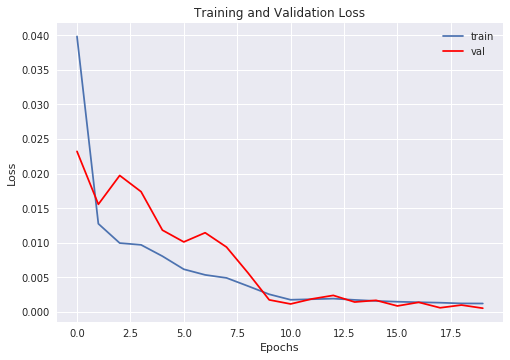

Test RMSE: 1.797
Test RMSE/std_dev: 0.702
Test MAE: 1.609


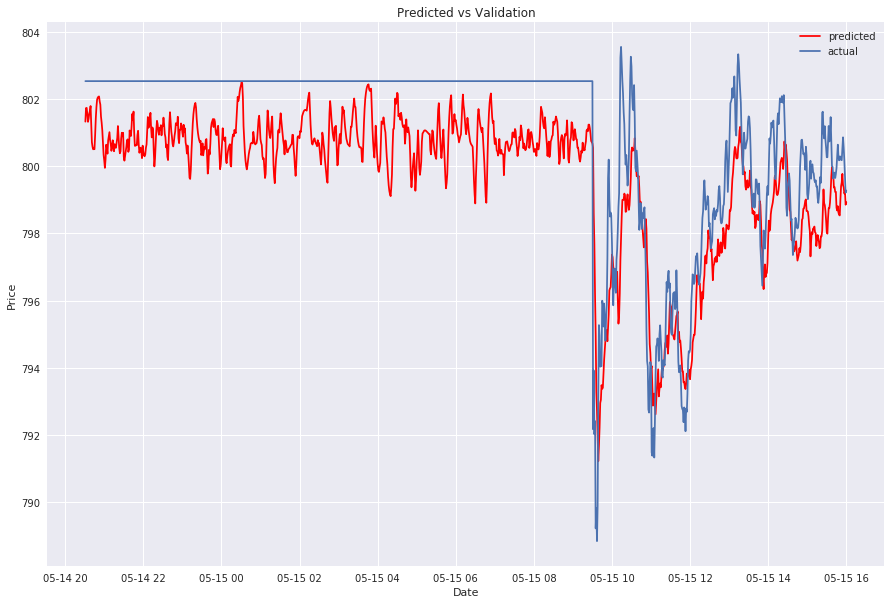

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 2.215
Test RMSE/std_dev: 0.325
Test MAE: 1.950


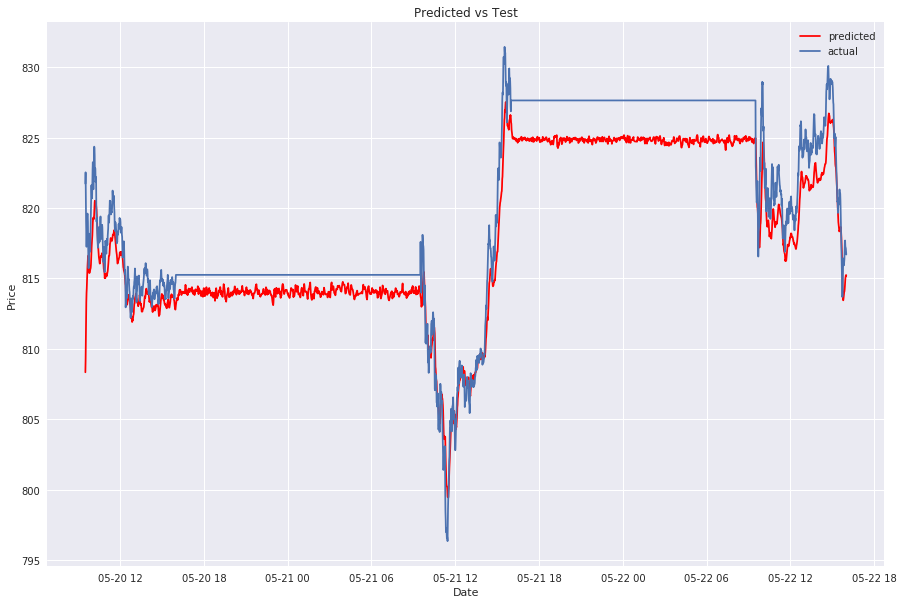

In [19]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(64, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

 # LSTM - 100 - short - tanh
 - 64-dimensional single layer
 - activation=tanh
 - epochs = 20
 - batch size = 100
 - 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


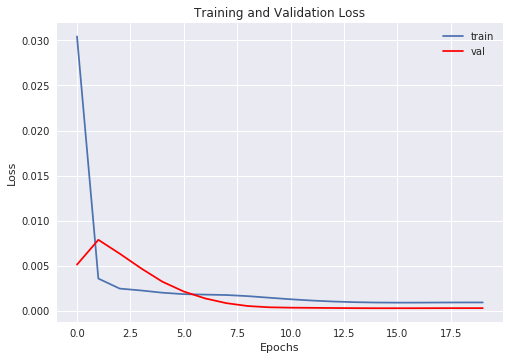

Test RMSE: 1.325
Test RMSE/std_dev: 0.179
Test MAE: 0.827


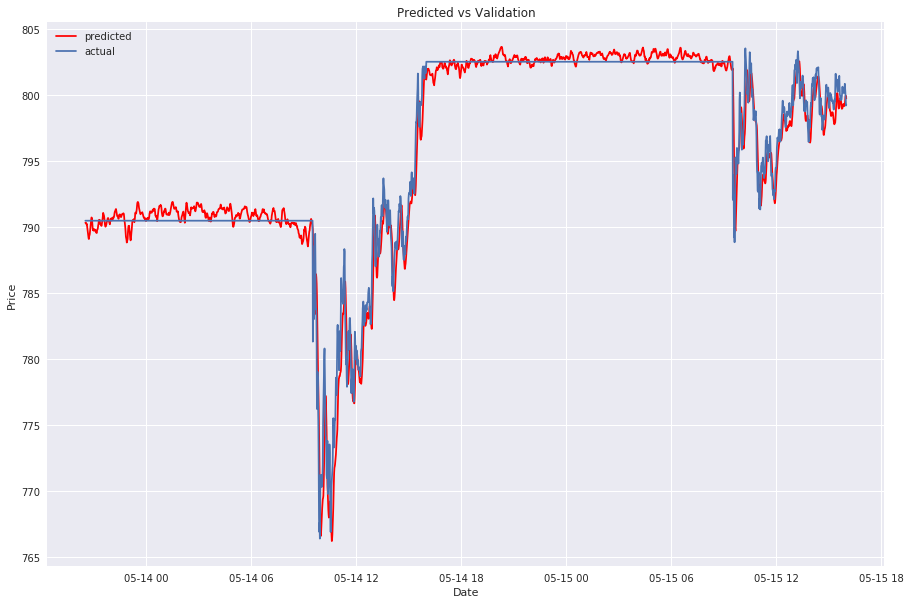

(3540, 270, 4) (3540,) (3265, 270, 4) (3265,)
Test RMSE: 1.127
Test RMSE/std_dev: 0.166
Test MAE: 0.801


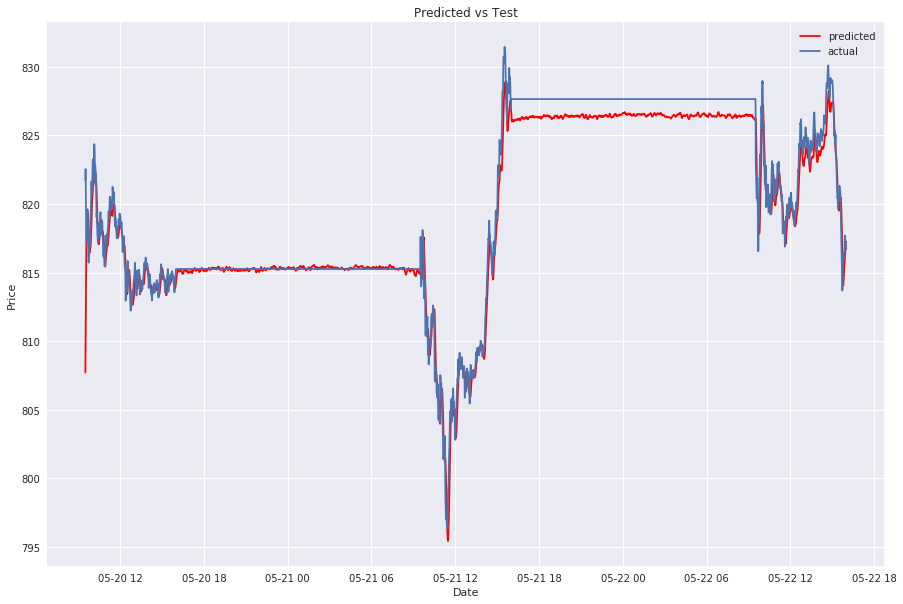

In [4]:
# load dataset
values = train_data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)
# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-2610:], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

 # LSTM - 100 - short - relu
 - 64-dimensional single layer
 - activation = relu
 - epochs = 20
 - batch size = 100
 - 2 nights and 2 days of predictions

(3540, 1080) 3540 (3540,)
(3540, 270, 4) (3540,) (2610, 270, 4) (2610,)


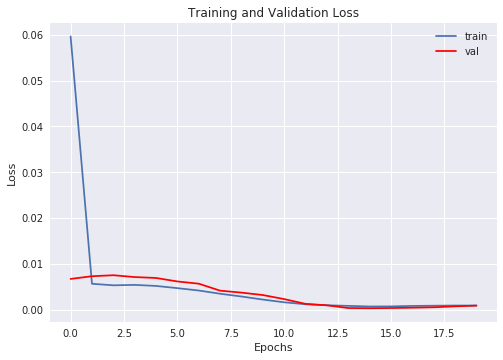

Test RMSE: 2.280
Test RMSE/std_dev: 0.308
Test MAE: 1.952


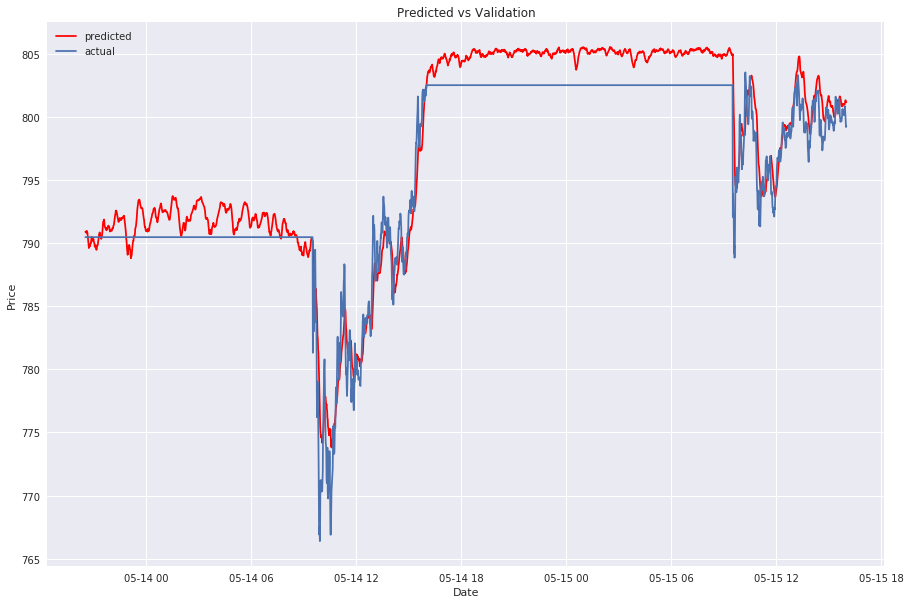

(3540, 270, 4) (3540,) (3265, 270, 4) (3265,)
Test RMSE: 1.170
Test RMSE/std_dev: 0.172
Test MAE: 0.856


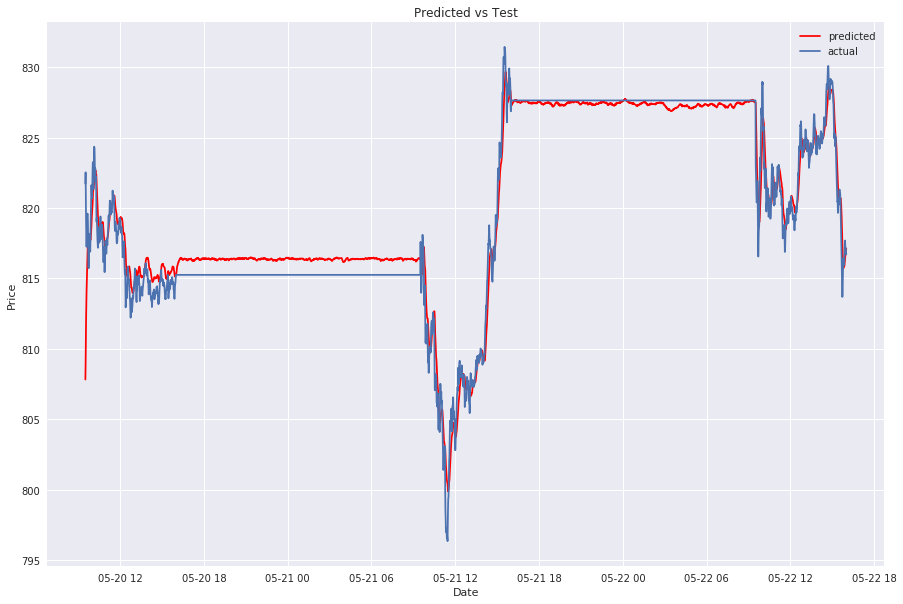

In [5]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-13 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(100, activation = 'relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-2610:], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-2610:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 100 - long - tanh
- 100-dimensional single layer
- activation = tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


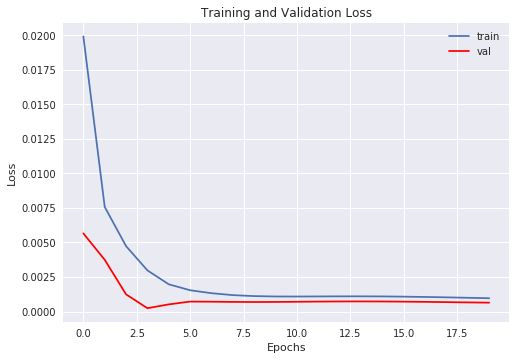

Test RMSE: 1.926
Test RMSE/std_dev: 0.753
Test MAE: 1.712


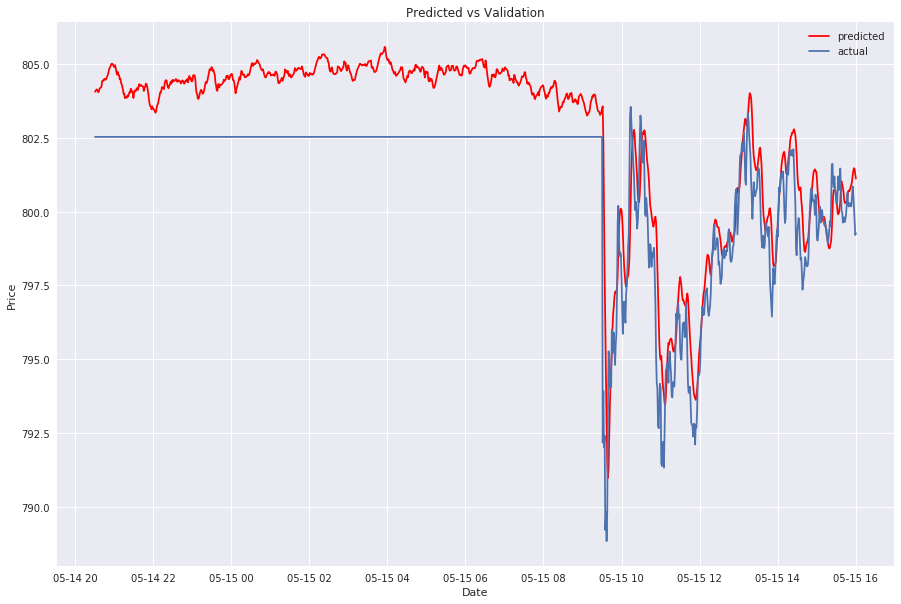

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 0.904
Test RMSE/std_dev: 0.133
Test MAE: 0.630


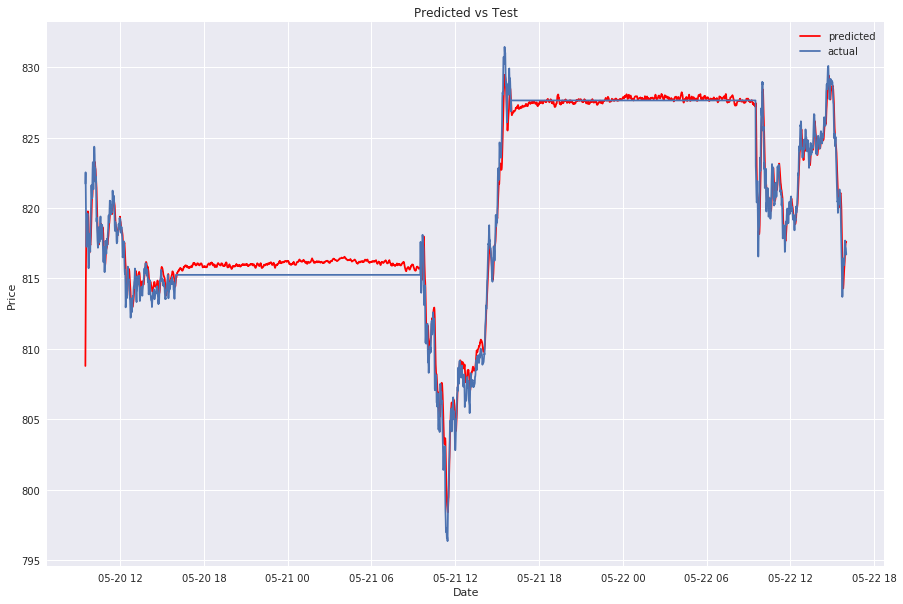

In [6]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM - 100 - long - relu
- 100-dimensional single layer
- activation=tanh
- epochs = 20
- batch size = 64
- 2 nights and 3 days of predictioins

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


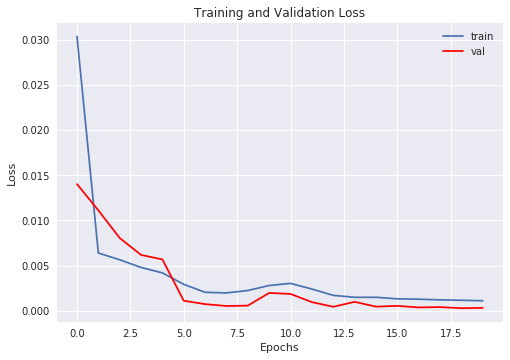

Test RMSE: 1.348
Test RMSE/std_dev: 0.527
Test MAE: 1.157


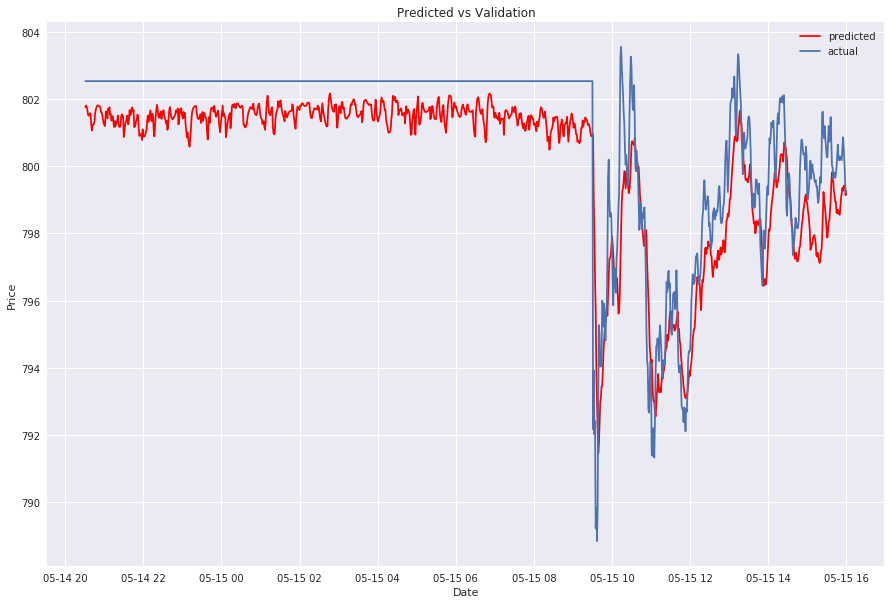

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 1.669
Test RMSE/std_dev: 0.245
Test MAE: 1.438


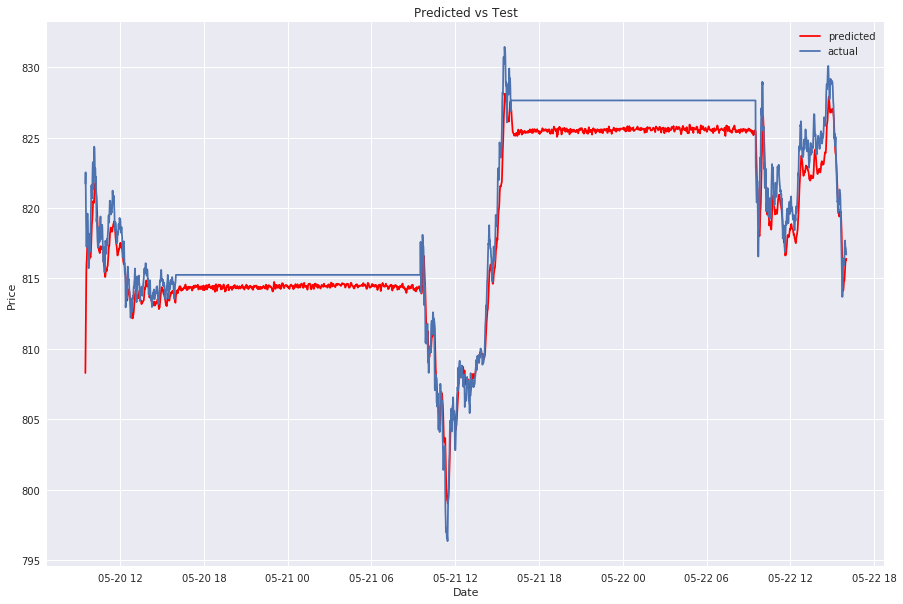

In [7]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(100, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# LSTM 128 - 64 - long - tanh
- 128-dimensional layer, 64-dimensional layer
- activation=tanh
- 2 nights and 2 days of predictions

(4980, 1080) 4980 (4980,)
(4980, 270, 4) (4980,) (1170, 270, 4) (1170,)


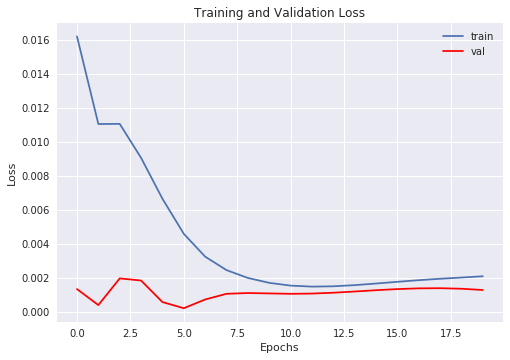

Test RMSE: 2.732
Test RMSE/std_dev: 1.068
Test MAE: 2.489


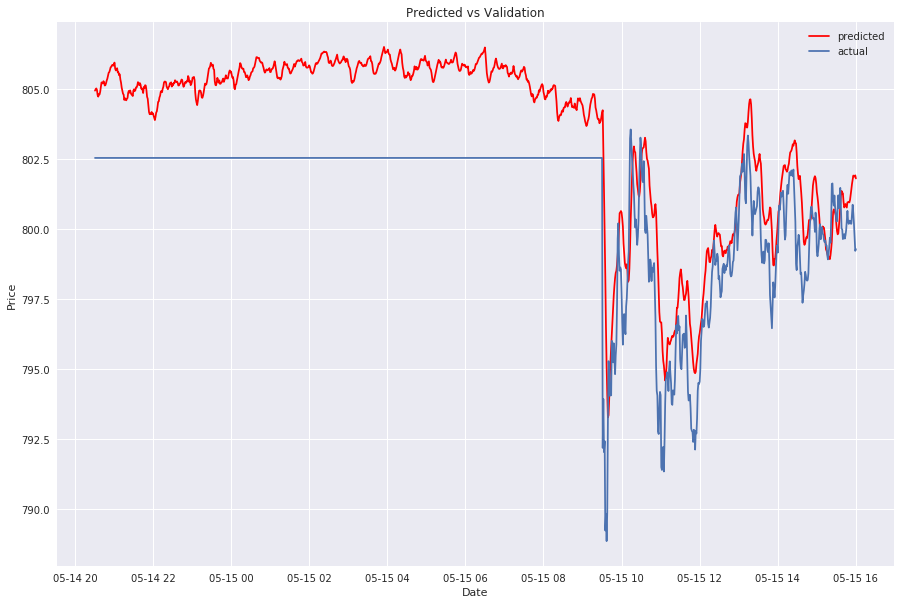

(4980, 270, 4) (4980,) (3265, 270, 4) (3265,)
Test RMSE: 1.313
Test RMSE/std_dev: 0.193
Test MAE: 1.114


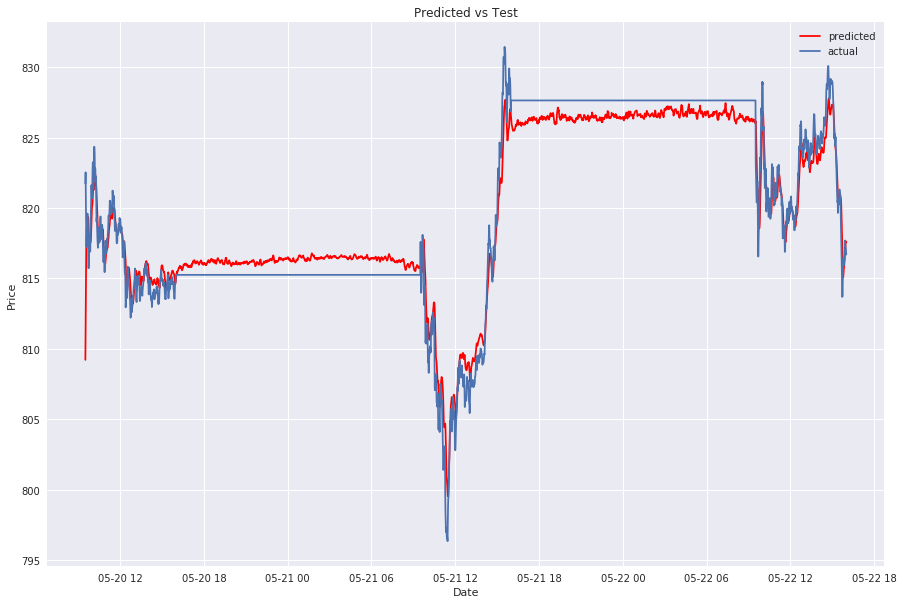

In [8]:
# load dataset
values = train_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag periods
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]

# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], window, features))
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.LSTM(128, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=64, validation_data=(test_X, test_y), verbose=0, shuffle=False, workers=4)

# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_pred):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], window, features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# Convolutional LSTM
- single 2D convolutional LSTM layer
- filters = 64
- kernel_size = (2,135)
- activation = relu
- epochs = 20
- batch size = 32

In [ ]:
# load dataset
values = train_data.values
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# specify the number of lag hours
window = 270
features = 4
# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into train and test sets
values = reframed.values
train_mins = len(train_data.loc[:'2020-05-14 16:00:00'])
train = values[:train_mins, :]
test = values[train_mins:, :]
# split into input and outputs
observations = window * features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, len(train_X), train_y.shape)
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1 ,3, 90, 4))
test_X = test_X.reshape((test_X.shape[0], 1, 3, 90, 4))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = tensorflow.keras.Sequential()
model.add(tensorflow.keras.layers.ConvLSTM2D(filters=270, kernel_size=(3,90), input_shape=(train_X.shape[1], 3, 90, 4)))
model.add(tensorflow.keras.layers.Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=100, batch_size=32, validation_data=(test_X, test_y), verbose=2, shuffle=False, workers=4)
# plot history
with plt.style.context('seaborn'):
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='val', color='red')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.show()

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
y_pred = y_pred.reshape(y_pred.shape[0],1)
# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]
# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Validation')
    plt.plot(train_data.index[-len(y_actual):], y_pred, label='predicted', color='red')
    plt.plot(train_data.index[-len(y_actual):], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()

# load dataset
values = test_data.values

# ensure all data is float
values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify the number of lag hours
window = 270
features = 4

# frame as supervised learning
reframed = tools.series_to_supervised(scaled, window, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[-3,-2,-1]], axis=1, inplace=True)

# split into input and outputs
values = reframed.values
observations = window * features
test_X, test_y = values[:, :-1], values[:, -1]
# reshape input to be 3D [samples, timesteps, features]
test_X = test_X.reshape((test_X.shape[0], 1, 3, 90, 4))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# make a prediction
y_pred = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], observations))
y_pred = y_pred.reshape(y_pred.shape[0],1)

# invert scaling for forecast
y_pred = np.concatenate((y_pred, test_X[:, -3:]), axis=1)
y_pred = scaler.inverse_transform(y_pred)
y_pred = y_pred[:,0]

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
y_actual = np.concatenate((test_y, test_X[:, -3:]), axis=1)
y_actual = scaler.inverse_transform(y_actual)
y_actual = y_actual[:,0]

# calculate RMSE
rmse = math.sqrt(mean_squared_error(y_actual, y_pred))
print('Test RMSE: %.3f' % rmse)
rmse_std = rmse/y_actual.std()
print('Test RMSE/std_dev: %.3f' % rmse_std)
mae = mean_absolute_error(y_actual, y_pred)
print('Test MAE: %.3f' % mae)

with plt.style.context('seaborn'):
    fig, ax = plt.subplots(1, figsize=(15,10))
    plt.title('Predicted vs Test')
    plt.plot(test_data.index[270:], y_pred, label='predicted', color='red')
    plt.plot(test_data.index[270:], y_actual, label='actual')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
plt.show()